# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [18]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
# The code is written with the help of OpenAI's ChatGPT.com

In [19]:
# Define a function to calculate interest rates from discount factors
def discount_to_intrate(discount, maturity, n_compound=None):

    # If the compounding frequency is not provided, assume continuous compounding
    if n_compound is None:
        # Calculate the continuously compounded interest rate
        intrate = - np.log(discount) / maturity
    else:
        # Calculate the interest rate with discrete compounding
        intrate = n_compound * (1 / discount**(1 / (n_compound * maturity)) - 1)
    
    # Return the computed interest rate
    return intrate

# Convert the Interest/Discount Rate to Discount Factor
def intrate_to_discount(intrate, maturity, n_compound=None):
    # Converts interest rates into discount factors for time value of money calculations.
    # If compounding frequency is not specified, continuous compounding is assumed.
    
    if n_compound is None:
        # Compute the discount factor using the continuous compounding formula:
        # discount = e^(-rate * maturity)
        discount = np.exp(-intrate * maturity)
    else:
        # Compute the discount factor using periodic compounding:
        # discount = 1 / (1 + rate/n_compound)^(n_compound * maturity)
        discount = 1 / (1 + (intrate / n_compound))**(n_compound * maturity)
    
    return discount  # Return the computed discount factor.

def get_coupon_dates(quote_date, maturity_date):
    # Check if quote_date is a string; if yes, convert it to a datetime object
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    # Check if maturity_date is a string; if yes, convert it to a datetime object
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # Calculate the number of semi-annual periods between quote_date and maturity_date
    # Use ceil to ensure we cover the full period (even if partial)
    num_periods = np.ceil((maturity_date - quote_date).days / 180)
    
    # Generate semi-annual dates going backward from the maturity date
    temp = pd.date_range(
        end=maturity_date, 
        periods=num_periods, 
        freq=pd.DateOffset(months=6)
    )
    
    # Keep only the dates that are after the quote date
    temp = pd.DataFrame(data=temp[temp > quote_date])
    
    # Extract the first column of the DataFrame and return it as the result
    out = temp[0]
    return out


def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    # Initialize an empty list to store the benchmark dates
    mask_benchmark_dts = []
    
    # Loop through each column (date) in the cash flow DataFrame
    for col in CF.columns:
        # If filtering by benchmark dates is enabled
        if filter_benchmark_dates:
            # Check if the date is one of the benchmark dates (Feb 15, May 15, Aug 15, Nov 15)
            if col.month in [2, 5, 8, 11] and col.day == 15:
                mask_benchmark_dts.append(col)  # Add it to the list of benchmark dates
        else:
            # If not filtering by benchmark dates, include all dates
            mask_benchmark_dts.append(col)

    # If filtering by maturity dates is enabled
    if filter_maturity_dates:
        # Select columns where at least one cash flow >= 100 (indicating maturity)
        mask_maturity_dts = CF.columns[(CF >= 100).any()]
    else:
        # If not filtering by maturity dates, include all columns
        mask_maturity_dts = CF.columns

    # Combine the two filters: Keep only dates present in both lists
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    # Filter the cash flow DataFrame to include only the selected dates
    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # Strict filtering: Keep only rows where cash flows on included dates match the original cash flows
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]
    else:
        # Lenient filtering: Keep rows with at least one non-zero cash flow on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
    # Remove columns (dates) where all cash flows are zero
    CF_filtered = CF_filtered.loc[:, (CF_filtered > 0).any()]
    
    # Return the filtered cash flow DataFrame
    return CF_filtered


def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['quote date'].values[-1]
    
    outdata = outdata[outdata['quote date']==t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['maturity date'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['maturity date'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['maturity date'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['type'].isin([11,12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['ytm']>0]
        
    return outdata


def calc_cashflows(quote_data, filter_maturity_dates=False):
    # Create an empty DataFrame to store cash flows
    # Rows represent individual securities (indexed by quote_data.index)
    # Columns represent unique maturity dates from the data
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    # Iterate over each security in the dataset
    for i in quote_data.index:
        # Get the semi-annual coupon payment dates for the security
        coupon_dates = get_coupon_dates(quote_data.loc[i, 'quote date'], quote_data.loc[i, 'maturity date'])

        # If coupon dates exist (not None), set coupon payment amounts
        if coupon_dates is not None:
            # Add semi-annual coupon payments (coupon rate divided by 2)
            CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / 2

        # Add the face value (100) at maturity
        CF.loc[i, quote_data.loc[i, 'maturity date']] += 100

    # Replace any NaN values with 0 and sort columns by date
    CF = CF.fillna(0).sort_index(axis=1)
    
    # Remove columns (dates) where all cash flows are zero
    CF.drop(columns=CF.columns[(CF == 0).all()], inplace=True)

    # If filtering by maturity dates is requested, apply the filter function
    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    # Return the final cash flow DataFrame
    return CF


def get_maturity_delta(t_maturity, t_current):
    # Calculates the time-to-maturity in years based on the difference between maturity date and current date.
    # Time is expressed as a fraction of a year (365.25 days to account for leap years).
    
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')  # Convert timedelta to years.
    
    return maturity_delta  # Return the time-to-maturity in years.

def bootstrap(params, maturity):
    # Extract estimated maturities from the first element of params
    estimated_maturities = params[0]
    # Extract corresponding discount factors (betas) from the second element of params
    betas = params[1]
    # Convert discount factors to interest rates using the discount_to_intrate function
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    # Create an interpolation function for the rates based on maturities
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    # Use the interpolation function to estimate the rate at the given maturity
    rate = f(maturity)
    
    # Return the interpolated rate
    return rate

def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    # Prices future cash flows using an interest rate model and optionally converts rates to discount factors.
    
    # Compute the time-to-maturity for all cash flow dates.
    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        # Initialize an array to store discount factors.
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            # Convert rates (from model) to discount factors using the specified model.
            disc[i] = intrate_to_discount(fun_model(params, mat), mat)
    else:
        # If no discounting is required, use rates directly from the model.
        disc = fun_model(params, maturity)
        
    if price_coupons:
        price = CF * disc
    else:
        # price = cash flow matrix multiply discount factors
        price = CF @ disc
    
    return price

def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    # Computes the difference (error) between observed market prices and model-derived prices.
    # The objective is to minimize this error during model calibration.

    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)  # Get model-derived prices.
    
    if isinstance(observed_prices, (pd.DataFrame, pd.Series)):
        # Convert observed prices to NumPy array if they are in Pandas format.
        observed_prices = observed_prices.values
    
    error = sum((observed_prices - price_modeled)**2)  # Compute the sum of squared differences.
    
    return error  # Return the sum of squared errors.

def nelson_siegel(params, maturity):
    # Nelson-Siegel model is used to fit yield curves with a combination of level, slope, and curvature components.
    # params: [beta_0, beta_1, beta_2, tau], where beta's control curve shape and tau is the decay factor.
    
    rate = (
        params[0] +  # Level component (long-term interest rate).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Weighted adjustment factor.
        params[2] * np.exp(-maturity / params[3])  # Curvature component decay.
    )
    return rate  # Return the modeled interest rate for the given maturity.

def nelson_siegel_extended(params, maturity):
    # Implements the extended Nelson-Siegel model for yield curve fitting.
    # params: A list of parameters [beta_0, beta_1, beta_2, tau_1, beta_3, tau_2]
    # - beta_0: Level parameter (long-term rate).
    # - beta_1: Slope parameter (short-term rate adjustment).
    # - beta_2: Curvature parameter (medium-term adjustment).
    # - tau_1: Decay factor for the slope and curvature components.
    # - beta_3: Second curvature parameter for additional flexibility.
    # - tau_2: Decay factor for the second curvature component.
    # maturity: Array or scalar of times to maturity (in years).

    rate = (
        params[0] +  # Long-term level component (constant for all maturities).
        (params[1] + params[2]) *  # Combined slope and curvature adjustment.
        (1 - np.exp(-maturity / params[3])) / (maturity / params[3]) -  # Slope/curvature weighted adjustment.
        params[2] * np.exp(-maturity / params[3]) +  # Exponential decay of the first curvature.
        params[4] * (  # Second curvature adjustment with separate parameters.
            (1 - np.exp(-maturity / params[5])) / (maturity / params[5]) -  # Weighted adjustment for second curvature.
            np.exp(-maturity / params[5])  # Exponential decay of the second curvature.
        )
    )
    
    return rate  # Returns the modeled interest rate for the given maturity.

def estimate_curve_ols(CF, prices, interpolate=False):
    # Estimates discount factors using linear regression (ordinary least squares).
    
    if isinstance(prices, (pd.DataFrame, pd.Series)):
        # Ensure the alignment between cash flows and observed prices.
        prices = prices[CF.index].values
    
    # Fit a regression model where cash flows explain observed prices (no intercept).
    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)
    
    if interpolate:
        # Interpolate discount factors to obtain a smooth curve.
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())  # Maturity grid for interpolation.
        
        # Identify valid discount factors within a reasonable range.
        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)
        
        xold = matgrid[dts_valid]  # Valid maturities.
        yold = mod.coef_[dts_valid]  # Valid discount factors.
        xnew = matgrid  # Full maturity grid.
        
        # Create an interpolation function to estimate discount factors for all maturities.
        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)  # Compute interpolated discount factors.
    else:
        discounts = mod.coef_  # Use OLS coefficients directly as discount factors.
        
    return discounts  # Return discount factors (direct or interpolated).

def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    # Estimates parameters for an interest rate curve model by minimizing pricing errors.
    
    if model is bootstrap:
        # Use bootstrap method to estimate discount factors first.
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        # Calculate maturities for each cash flow.
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
        
        # Combine maturities and corresponding discount factors as model parameters.
        params_optimized = [CF_intervals, params]
    else:
        # Provide default initial guess if none is specified.
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10  # Default guess for Nelson-Siegel model parameters.
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)  # Default guess for extended model.
            else:
                x0 = 1  # Generic default initial guess.
        
        # Optimize the model parameters to minimize pricing errors.
        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x  # Extract optimized parameters.
    
    return params_optimized  # Return the estimated model parameters.


def price_treasury_ytm(yield_to_maturity, coupon_rate, face_value, time_to_maturity, payments_per_year=2):
    """
    Prices a Treasury bond based on its yield to maturity, coupon rate, face value, and time to maturity.

    Parameters:
        yield_to_maturity (float): The annual yield to maturity (as a decimal, e.g., 0.03 for 3%).
        coupon_rate (float): The annual coupon rate (as a decimal, e.g., 0.02 for 2%).
        face_value (float): The face value (par value) of the bond.
        time_to_maturity (float): The time to maturity of the bond in years.
        payments_per_year (int): The number of coupon payments per year (default is 2 for semi-annual payments).

    Returns:
        float: The price of the Treasury bond.
    """
    # Calculate the coupon payment per period
    coupon_payment = coupon_rate * face_value / payments_per_year

    # Total number of periods
    total_periods = int(time_to_maturity * payments_per_year)

    # Periodic yield to maturity
    periodic_yield = yield_to_maturity / payments_per_year

    # Price calculation: Sum of discounted coupon payments + discounted face value
    price = 0

    for t in range(1, total_periods + 1):
        price += coupon_payment / (1 + periodic_yield) ** t

    # Add the present value of the face value (paid at maturity)
    price += face_value / (1 + periodic_yield) ** total_periods

    return price

# Duration for a fixed rate bond
# freq = frequency of compounding in a year
# tau = years-to-maturity

def duration_closed_formula(tau, ytm, coupon_rate=None, freq=2):

    if coupon_rate is None:
        coupon_rate = ytm
        
    # y_tilde = ytm/frequency
    y = ytm/freq
    # c_tilde = coupon rate/ frequency
    c = coupon_rate/freq
    # tau_tilde= tau * frequency
    T = tau * freq
        
    if coupon_rate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.




In [20]:
# Importing the excel file
filepath_rawdata = '/Users/matheus/Desktop/finm-fixedincome-2025/data/treasury_ts_2015-08-15.xlsx'
info_df = pd.read_excel(filepath_rawdata,sheet_name='info')

# Set the first row as header
info_df.columns = info_df.iloc[0]  # Set the first row as the header
info_df = info_df[1:].reset_index(drop=True)  # Remove the first row and reset the index

# Set the first column 'kytreasno' as the index
info_df = info_df.set_index('kytreasno')

# Filter the DataFrame to include only rows where the index is 'kytreasno', 'tcouprt', or 'tvalfc'
filter_info = info_df.loc[['tcouprt', 'tvalfc']]

# Rename rows
filter_info.rename(index={
    'tcouprt': 'Coupon Rate',
    'tvalfc': 'Face Value'
}, inplace=True)

# Display the filtered DataFrame
filter_info

,204046,204047,206524
kytreasno,,,
Coupon Rate,10.625,4.25,0.25
Face Value,5.3125,2.125,0.125


In [21]:
# Grab the coupon rates
coupon_rate_204046 = filter_info.loc['Coupon Rate', 204046]
coupon_rate_204047 = filter_info.loc['Coupon Rate', 204047]

# Display the coupon rate
print(coupon_rate_204046, coupon_rate_204047)

10.625 4.25


In [28]:
# Importing the excel file
filepath_rawdata = '/Users/matheus/Desktop/finm-fixedincome-2025/data/treasury_ts_2015-08-15.xlsx'
raw_df = pd.read_excel(filepath_rawdata,sheet_name='database')

raw_df.columns = raw_df.columns.str.upper()

raw_df.rename(columns={
    'CALDT': 'quote date',
    'TMATDT': 'maturity date',
    'TCOUPRT': 'cpn rate',
    'TDBID': 'bid',
    'TDASK': 'ask',
    'TDNOMPRC': 'clean price',
    'TDACCINT': 'accrued int',
    'TDYLD': 'ytm',
    'TDDURATN': 'duration'
}, inplace=True)

# Set the KYTREASNO column as the index
raw_df.set_index('KYTREASNO', inplace=True)

days_adj = 365.25

# Annualize the columns
raw_df['duration'] = raw_df['duration']/days_adj
raw_df['ytm'] = raw_df['ytm']*days_adj

# Add Dirty Price
raw_df['dirty price'] =  ((raw_df['bid'] + raw_df['ask']) / 2) + raw_df['accrued int']

# Add Modified Duration
raw_df['modified duration'] =  raw_df['duration']/(1+raw_df['ytm']/2)

# Filter the DataFrame
filtered_df = raw_df[raw_df['quote date'] == '2008-11-04']

# Add Coupon Rate
filtered_df['coupon rate'] =  (coupon_rate_204047, coupon_rate_204046)

filtered_df

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_76296/1004672769.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['coupon rate'] =  (coupon_rate_204047, coupon_rate_204046)


,KYCRSPID,quote date,bid,ask,clean price,TDNOMPRC_FLG,TDSOURCR,accrued int,TDRETNUA,ytm,duration,TDPUBOUT,TDTOTOUT,TDPDINT,TDIDXRATIO,TDIDXRATIO_FLG,dirty price,modified duration,coupon rate
KYTREASNO,,,,,,,,,,,,,,,,,,,
204047,2.015082e+07,2008-11-04,105.953125,105.984375,105.96875,M,X,0.935462,0.011642,0.032362,5.935706,20998.0,32470.0,0.0,NaN,NaN,106.904212,5.841189,4.250
204046,2.015082e+07,2008-11-04,141.859375,141.890625,141.87500,M,X,2.338655,0.009720,0.035753,5.230138,2852.0,4024.0,0.0,NaN,NaN,144.213655,5.138284,10.625


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM


In [29]:
summary_df = filtered_df[['quote date', 'coupon rate', 'bid','ask','accrued int', 'clean price',
                          'dirty price', 'duration', 'modified duration', 'ytm']].T

# Switch the positions of columns 204047 and 204046
summary_df = summary_df[[204046, 204047]]

# Display the updated DataFrame
summary_df

KYTREASNO,204046,204047
quote date,2008-11-04 00:00:00,2008-11-04 00:00:00
coupon rate,10.625,4.25
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued int,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706
modified duration,5.138284,5.841189
ytm,0.035753,0.032362


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [30]:
# Inputs
data = summary_df
long_capital = 50_000_000 # Capital for long position
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset
duration_long = data.loc['duration', 204046] # duration for long asset
duration_short = data.loc['duration', 204047]  # duration for short asset

# Calculate number of bonds for long position
n_i = long_capital / price_long

# Calculate hedge ratio and number of notes for short position
hedge_ratio = (price_long * duration_long) / (price_short * duration_short)
n_j = -n_i * hedge_ratio

# Calculate total value of the short position
short_position_value = n_j * price_short

# Print results
print(f"Long Position: Number of contracts: {n_i:,.2f}")
print(f"Long Position: Market value: ${long_capital:,.2f}")

print(f"Short Position: Number of contracts: {-n_j:,.2f}")
print(f"Short Position: Market value: ${short_position_value:,.2f}")

Long Position: Number of contracts: 346,707.81
Long Position: Market value: $50,000,000.00
Short Position: Number of contracts: 412,112.66
Short Position: Market value: $-44,056,578.93


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

In [39]:
# Inputs
data = summary_df
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset
modified_duration_long = data.loc['modified duration', 204046] 
modified_duration_short = data.loc['modified duration', 204047]

# YTM Spread
ytm_spread = data.loc['ytm', 204046] - data.loc['ytm', 204047]
# delta_y = Convergence from each side
delta_y = 0.5/10_000

# Calculate PnL for long position 
pnl_long = -modified_duration_long * n_i * price_long * (-delta_y)

# Calculate PnL for short position
pnl_short = -modified_duration_short * n_j * price_short * delta_y

# Net PnL
net_pnl = pnl_long + pnl_short

# Print the results
print(f"Spread Convergence: {delta_y*2*100:,.2f} bps")
print(f"PnL from long position: ${pnl_long:,.2f}")
print(f"PnL from short position: ${pnl_short:,.2f}")
print(f"Net Total PnL: ${net_pnl:,.2f}")

Spread Convergence: 0.01 bps
PnL from long position: $12,845.71
PnL from short position: $12,867.14
Net Total PnL: $25,712.85


In [32]:
data = summary_df
ytm_spread = data.loc['ytm', 204046] - data.loc['ytm', 204047]
delta_y = ytm_spread/2 
delta_y*10_000

16.951556720897972

In [40]:
# Inputs
data = summary_df
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset
modified_duration_long = data.loc['modified duration', 204046] 
modified_duration_short = data.loc['modified duration', 204047]

# YTM Spread
ytm_spread = data.loc['ytm', 204046] - data.loc['ytm', 204047]
# delta_y = Convergence from each side
delta_y = ytm_spread/2 

# Calculate PnL for long position 
pnl_long = -modified_duration_long * n_i * price_long * (-delta_y)

# Calculate PnL for short position
pnl_short = -modified_duration_short * n_j * price_short * delta_y

# Net PnL
net_pnl = pnl_long + pnl_short

# Print the results
print(f"YTM Spread: {ytm_spread*10_000:,.2f} bps")
print(f"PnL from long position: ${pnl_long:,.2f}")
print(f"PnL from short position: ${pnl_short:,.2f}")
print(f"Net Total PnL: ${net_pnl:,.2f}")

YTM Spread: 33.90 bps
PnL from long position: $435,509.58
PnL from short position: $436,236.08
Net Total PnL: $871,745.67


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

In [41]:
# Filter the DataFrame for 2008-11-25
filtered_df_2 = raw_df[raw_df['quote date'] == '2008-11-25']

summary_df_2 = filtered_df_2[['quote date', 'clean price',
                          'dirty price', 'duration', 'modified duration', 'ytm']].T

# Switch the positions of columns 204047 and 204046
summary_df_2 = summary_df_2[[204046, 204047]]

# Display the updated DataFrame
display(summary_df_2)

data = summary_df_2
ytm_spread_new = data.loc['ytm', 204046] - data.loc['ytm', 204047]
ytm_spread_new_bps = ytm_spread_new*10000

print(f"New YTM Spread is: {ytm_spread_new_bps:,.2f} bps")

KYTREASNO,204046,204047
quote date,2008-11-25 00:00:00,2008-11-25 00:00:00
clean price,145.875,110.8125
dirty price,148.819973,111.990489
duration,5.199097,5.901686
modified duration,5.122046,5.829439
ytm,0.030086,0.024787


New YTM Spread is: 52.99 bps


In [44]:
data = summary_df
trade_date = "2008-11-04"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_1 = n_i * price_long
position_short_1 = n_j * price_short
position_size_1 =  n_i * price_long + n_j * price_short
# print(f"For trade date: {trade_date}")
# print(f"Long position size: ${position_long_1:,.2f}")
# print(f"Short position size: ${position_short_1:,.2f}")
# print(f"Total position size: ${position_size_1:,.2f}\n")

data = summary_df_2
trade_date = "2008-11-25"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_2 = n_i * price_long
position_short_2 = n_j * price_short
position_size_2 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_2:,.2f}")
print(f"Short position size: ${position_short_2:,.2f}")
print(f"Total position size: ${position_size_2:,.2f}\n")

pnl_long = position_long_2 - position_long_1 
pnl_short = position_short_2 - position_short_1
pnl_net = pnl_long + pnl_short

print(f"For trade date: {trade_date}")
print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

For trade date: 2008-11-25
Long position size: $51,597,046.39
Short position size: $-46,152,698.14
Total position size: $5,444,348.25

For trade date: 2008-11-25
PnL - Long Position: $1,597,046.39
PnL - Short Position: $-2,096,119.20
PnL - Net: $-499,072.82


In [45]:
# Filter the DataFrame for 2008-12-16
filtered_df_3 = raw_df[raw_df['quote date'] == '2008-12-16']

summary_df_3 = filtered_df_3[['quote date', 'clean price',
                          'dirty price', 'duration', 'modified duration', 'ytm']].T

# Switch the positions of columns 204047 and 204046
summary_df_3 = summary_df_3[[204046, 204047]]

# Display the updated DataFrame
display(summary_df_3)

data = summary_df_3
ytm_spread_new = data.loc['ytm', 204046] - data.loc['ytm', 204047]
ytm_spread_new_bps = ytm_spread_new*10000

print(f"New YTM Spread is: {ytm_spread_new_bps:,.2f} bps")

KYTREASNO,204046,204047
quote date,2008-12-16 00:00:00,2008-12-16 00:00:00
clean price,151.9375,117.515625
dirty price,155.488791,118.936141
duration,5.179087,5.874297
modified duration,5.122922,5.831261
ytm,0.021927,0.01476


New YTM Spread is: 71.66 bps


In [47]:
data = summary_df
trade_date = "2008-11-04"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_1 = n_i * price_long
position_short_1 = n_j * price_short
position_size_1 =  n_i * price_long + n_j * price_short
# print(f"For trade date: {trade_date}")
# print(f"Long position size: ${position_long_1:,.2f}")
# print(f"Short position size: ${position_short_1:,.2f}")
# print(f"Total position size: ${position_size_1:,.2f}\n")

data = summary_df_3
trade_date = "2008-12-16"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_2 = n_i * price_long
position_short_2 = n_j * price_short
position_size_2 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_2:,.2f}")
print(f"Short position size: ${position_short_2:,.2f}")
print(f"Total position size: ${position_size_2:,.2f}\n")

pnl_long = position_long_2 - position_long_1 
pnl_short = position_short_2 - position_short_1
pnl_net = pnl_long + pnl_short

print(f"For trade date: {trade_date}")
print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

For trade date: 2008-12-16
Long position size: $53,909,177.63
Short position size: $-49,015,089.31
Total position size: $4,894,088.32

For trade date: 2008-12-16
PnL - Long Position: $3,909,177.63
PnL - Short Position: $-4,958,510.38
PnL - Net: $-1,049,332.75


## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [50]:
# Filter the DataFrame for 2009-01-27
filtered_df_3 = raw_df[raw_df['quote date'] == '2009-01-27']

summary_df_3 = filtered_df_3[['quote date', 'clean price',
                          'dirty price', 'duration', 'modified duration', 'ytm']].T

# Switch the positions of columns 204047 and 204046
summary_df_3 = summary_df_3[[204046, 204047]]

# Display the updated DataFrame
display(summary_df_3)

data = summary_df_3
ytm_spread_new = data.loc['ytm', 204046] - data.loc['ytm', 204047]
ytm_spread_new_bps = ytm_spread_new*10000

print(f"New YTM Spread is: {ytm_spread_new_bps:,.2f} bps")

data = summary_df_3
trade_date = "2009-01-27"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_2 = n_i * price_long
position_short_2 = n_j * price_short
position_size_2 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_2:,.2f}")
print(f"Short position size: ${position_short_2:,.2f}")
print(f"Total position size: ${position_size_2:,.2f}\n")

pnl_long = position_long_2 - position_long_1 
pnl_short = position_short_2 - position_short_1
pnl_net = pnl_long + pnl_short

print(f"For trade date: {trade_date}")
print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

KYTREASNO,204046,204047
quote date,2009-01-27 00:00:00,2009-01-27 00:00:00
clean price,150.46875,114.21875
dirty price,155.232677,116.124321
duration,5.060345,5.746067
modified duration,5.003431,5.691389
ytm,0.02275,0.019214


New YTM Spread is: 35.36 bps
For trade date: 2009-01-27
Long position size: $53,820,380.86
Short position size: $-47,856,302.43
Total position size: $5,964,078.43

For trade date: 2009-01-27
PnL - Long Position: $3,820,380.86
PnL - Short Position: $-3,799,723.50
PnL - Net: $20,657.36


In [54]:
# Calculate the coupon payment
# Coupon payment needs to be manually adjusted to become a semi-annual rate and convert to real numbers (x 0.01)
# Multiply the coupon to the Par Value
# Coupon Payment for Security A = Number of unit of Security A * (Annual Coupon Rate)/2 * Par Value 
par_value = 100
coupon_payment_long = n_i * (coupon_rate_204046 / 2) * 0.01 * par_value
coupon_payment_short = n_j * (coupon_rate_204047 / 2) * 0.01 * par_value
coupon_payment = coupon_payment_long + coupon_payment_short
print(f"Total Coupon Payment: ${coupon_payment:,.2f}")

Total Coupon Payment: $966,145.83


In [56]:
# Filter the DataFrame for 2009-03-24
filtered_df_3 = raw_df[raw_df['quote date'] == '2009-03-24']

summary_df_3 = filtered_df_3[['quote date', 'clean price',
                          'dirty price', 'duration', 'modified duration', 'ytm']].T

# Switch the positions of columns 204047 and 204046
summary_df_3 = summary_df_3[[204046, 204047]]

# Display the updated DataFrame
display(summary_df_3)

data = summary_df_3
ytm_spread_new = data.loc['ytm', 204046] - data.loc['ytm', 204047]
ytm_spread_new_bps = ytm_spread_new*10000

print(f"New YTM Spread is: {ytm_spread_new_bps:,.2f} bps")

data = summary_df_3
trade_date = "2009-03-24"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_2 = n_i * price_long
position_short_2 = n_j * price_short
position_size_2 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_2:,.2f}")
print(f"Short position size: ${position_short_2:,.2f}")
print(f"Total position size: ${position_size_2:,.2f}\n")

pnl_long = position_long_2 - position_long_1 + coupon_payment_long
pnl_short = position_short_2 - position_short_1 + coupon_payment_short
pnl_net = pnl_long + pnl_short

print(f"For trade date: {trade_date}")
print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

KYTREASNO,204046,204047
quote date,2009-03-24 00:00:00,2009-03-24 00:00:00
clean price,149.882812,113.476562
dirty price,150.968793,113.910955
duration,5.08685,5.697178
modified duration,5.03132,5.641131
ytm,0.022074,0.019871


New YTM Spread is: 22.03 bps
For trade date: 2009-03-24
Long position size: $52,342,059.17
Short position size: $-46,944,146.33
Total position size: $5,397,912.84

For trade date: 2009-03-24
PnL - Long Position: $4,183,944.40
PnL - Short Position: $-3,763,306.80
PnL - Net: $420,637.60


In [57]:
# Filter the DataFrame for 2009-06-16
filtered_df_3 = raw_df[raw_df['quote date'] == '2009-06-16']

summary_df_3 = filtered_df_3[['quote date', 'clean price',
                          'dirty price', 'duration', 'modified duration', 'ytm']].T

# Switch the positions of columns 204047 and 204046
summary_df_3 = summary_df_3[[204046, 204047]]

# Display the updated DataFrame
display(summary_df_3)

data = summary_df_3
ytm_spread_new = data.loc['ytm', 204046] - data.loc['ytm', 204047]
ytm_spread_new_bps = ytm_spread_new*10000

print(f"New YTM Spread is: {ytm_spread_new_bps:,.2f} bps")

data = summary_df_3
trade_date = "2009-06-16"
price_long = data.loc['dirty price', 204046]  # Price for long asset
price_short = data.loc['dirty price', 204047]  # Price for short asset

# Position size : Number of security x Price of each security
position_long_2 = n_i * price_long
position_short_2 = n_j * price_short
position_size_2 =  n_i * price_long + n_j * price_short
print(f"For trade date: {trade_date}")
print(f"Long position size: ${position_long_2:,.2f}")
print(f"Short position size: ${position_short_2:,.2f}")
print(f"Total position size: ${position_size_2:,.2f}\n")

pnl_long = position_long_2 - position_long_1 + coupon_payment_long
pnl_short = position_short_2 - position_short_1 + coupon_payment_short
pnl_net = pnl_long + pnl_short

print(f"For trade date: {trade_date}")
print(f"PnL - Long Position: ${pnl_long:,.2f}")
print(f"PnL - Short Position: ${pnl_short:,.2f}")
print(f"PnL - Net: ${pnl_net:,.2f}")

KYTREASNO,204046,204047
quote date,2009-06-16 00:00:00,2009-06-16 00:00:00
clean price,142.75,106.671875
dirty price,146.30145,108.092455
duration,4.828033,5.44121
modified duration,4.757603,5.359949
ytm,0.029607,0.030321


New YTM Spread is: -7.14 bps
For trade date: 2009-06-16
Long position size: $50,723,854.96
Short position size: $-44,546,268.97
Total position size: $6,177,585.98

For trade date: 2009-06-16
PnL - Long Position: $2,565,740.18
PnL - Short Position: $-1,365,429.44
PnL - Net: $1,200,310.74


***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [25]:
import pandas as pd

In [26]:
QUOTE_DATE = '2024-10-31'
filepath = f'../data/treasury_ts_duration_{QUOTE_DATE}.xlsx'

data = pd.read_excel(filepath,sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.625
207392,bond,2019-08-15,2049-08-15,2.250


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [61]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

px = pd.read_excel(filepath,sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel(filepath,sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

display(px)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.882812,99.789062
2019-08-12,99.796875,102.554688
2019-08-13,99.281250,101.867188
2019-08-14,100.406250,105.179688
2019-08-15,100.882812,106.234375
...,...,...
2024-11-22,88.740234,63.722656
2024-11-25,89.287109,65.378906
2024-11-26,89.214844,65.175781


,207391,207392
quote date,,
2019-08-09,9.289497,22.000102
2019-08-12,9.285468,22.118496
2019-08-13,9.280314,22.084308
2019-08-14,9.282750,22.228549
2019-08-15,9.282163,22.270910
...,...,...
2024-11-22,4.539445,17.205511
2024-11-25,4.531983,17.312267
2024-11-26,4.529132,17.295472


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?








In [62]:
# Inputs
data = px
long_capital = 10_000_000 # Capital for long position
trade_date = "2019-08-09"
price_long = px.loc[trade_date, 207391]  # Price for long asset
price_short = px.loc[trade_date, 207392]  # Price for short asset
duration_long = duration.loc[trade_date, 207391] # duration for long asset
duration_short = duration.loc[trade_date, 207392]  # duration for short asset

# Calculate number of bonds for long position
n_i = long_capital / price_long

# Calculate hedge ratio and number of notes for short position
hedge_ratio = (price_long * duration_long) / (price_short * duration_short)
n_j = -n_i * hedge_ratio

# Calculate total value of the short position
short_position_value = n_j * price_short

# Print results
print(f"Long Position: Number of contracts: {n_i:,.2f}")
print(f"Long Position: Market value: ${long_capital:,.2f}")

print(f"Short Position: Number of contracts: {-n_j:,.2f}")
print(f"Short Position: Market value: ${short_position_value:,.2f}")

Long Position: Number of contracts: 101,129.81
Long Position: Market value: $10,000,000.00
Short Position: Number of contracts: 42,314.05
Short Position: Market value: $-4,222,479.08


### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.

In [66]:
SIZE = 10000
IDLONG = 207391
IDSHORT = 207392
FREQ = 365.25

# Make a new dataframe with the same index as the duration column
position = pd.DataFrame(index=duration.index, dtype=float)

# Number of security we are long = size / price of security
position['Number of Securities Long'] = SIZE / px[IDLONG]

# Hedge Ratio = (Price long x Duration Long) / (Price Short x Duration Short)
position['Hedge Ratio'] = (px[IDLONG] * duration[IDLONG]) / (px[IDSHORT] * duration[IDSHORT])

# Number of security we are short = Hedge Ratio x Number of security we are long
position['Number of Securities Short'] = - position['Hedge Ratio'] * position['Number of Securities Long']

# Position = Number of securities x price of each security
position['Long Position ($)'] = position['Number of Securities Long'] * px[IDLONG].values
position['Short Position ($)'] = position['Number of Securities Short'] * px[IDSHORT].values

# Net Position = Long Position + Short Position
position['Net Position ($)'] = position['Long Position ($)'] + position['Short Position ($)']

position.head()

,Number of Securities Long,Hedge Ratio,Number of Securities Short,Long Position ($),Short Position ($),Net Position ($)
quote date,,,,,,
2019-08-09,101.129810,0.418413,-42.314047,10000.0,-4222.479083,5777.520917
2019-08-12,100.203538,0.408517,-40.934802,10000.0,-4198.055835,5801.944165
2019-08-13,100.723953,0.409555,-41.251958,10000.0,-4202.220951,5797.779049
2019-08-14,99.595394,0.398652,-39.703946,10000.0,-4176.048586,5823.951414
2019-08-15,99.124913,0.395789,-39.232518,10000.0,-4167.842047,5832.157953


## Checking if there is a daily duration hedge

In [67]:
# Make a new dataframe for the weights with the same index as the duration column
weight_df = pd.DataFrame(index=duration.index, dtype=float)
weight_df['Long Weight'] = position['Long Position ($)'] / position['Net Position ($)']
weight_df['Short Weight'] = position['Short Position ($)'] / position['Net Position ($)']
weight_df.head()

,Long Weight,Short Weight
quote date,,
2019-08-09,1.730846,-0.730846
2019-08-12,1.723560,-0.723560
2019-08-13,1.724798,-0.724798
2019-08-14,1.717047,-0.717047
2019-08-15,1.714631,-0.714631


In [68]:
# Checking duration is neutralized
# Weighted Duration = Long Weight * Long Duration + Short Weight * Short Duration
position['Duration'] = (weight_df * duration[[IDLONG,IDSHORT]].values).sum(axis=1)

# Use describe to show the statistics
dur_stat = position['Duration'].describe().to_frame().T.style.format('{:.2%}')
display(dur_stat)

print("We see that the durations are showing 0s. The net duration is 0 at all stages.")

,count,mean,std,min,25%,50%,75%,max
Duration,133000.00%,0.00%,0.00%,-0.00%,-0.00%,0.00%,0.00%,0.00%


We see that the durations are showing 0s. The net duration is 0 at all stages.


In [70]:
# Realized Position = Next Day Position = Number of securities being held x price at the next day(t+1)
position['Long ($) realized'] = position['Number of Securities Long'] * px[IDLONG].shift(-1).values
position['Short ($) realized'] = position['Number of Securities Short'] * px[IDSHORT].shift(-1).values

# PnL = Next Day Position (Realized Position) - Position Today
position['Long PnL'] = position['Long ($) realized'] - position['Long Position ($)']
position['Short PnL'] = position['Short ($) realized'] - position['Short Position ($)']

# Profit from hedged strategy = Long PnL + Short PnL
position['Profit Hedged'] = position['Long PnL'] + position['Short PnL']

# Price change = Price at t+1 - Price at t
# Unhedged Profit = Price change x number of securities long at t
position['Profit Unhedged'] = px[IDLONG].diff() * position['Number of Securities Long'].shift()

position.head()

,Number of Securities Long,Hedge Ratio,Number of Securities Short,Long Position ($),Short Position ($),Net Position ($),Duration,Long ($) realized,Short ($) realized,Long PnL,Short PnL,Profit Hedged,Profit Unhedged
quote date,,,,,,,,,,,,,
2019-08-09,101.129810,0.418413,-42.314047,10000.0,-4222.479083,5777.520917,3.552714e-15,10092.438967,-4339.503869,92.438967,-117.024786,-24.585820,NaN
2019-08-12,100.203538,0.408517,-40.934802,10000.0,-4198.055835,5801.944165,-3.552714e-15,9948.332550,-4169.913158,-51.667450,28.142676,-23.524773,92.438967
2019-08-13,100.723953,0.409555,-41.251958,10000.0,-4202.220951,5797.779049,-3.552714e-15,10113.314448,-4338.868062,113.314448,-136.647111,-23.332664,-51.667450
2019-08-14,99.595394,0.398652,-39.703946,10000.0,-4176.048586,5823.951414,0.000000e+00,10047.463430,-4217.923841,47.463430,-41.875255,5.588175,113.314448
2019-08-15,99.124913,0.395789,-39.232518,10000.0,-4167.842047,5832.157953,5.329071e-15,9975.993185,-4110.525790,-24.006815,57.316257,33.309442,47.463430


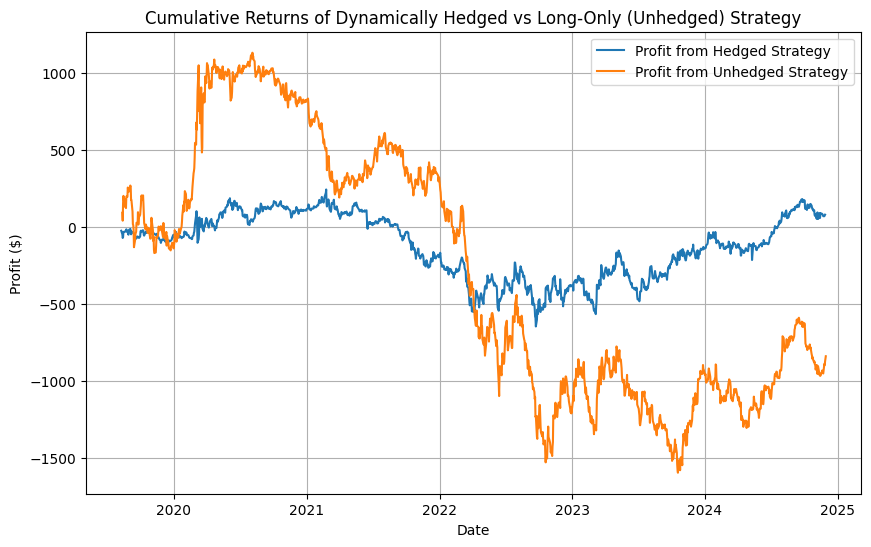

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(position.index, position['Profit Hedged'].cumsum(), label='Profit from Hedged Strategy')
plt.plot(position.index, position['Profit Unhedged'].cumsum(), label='Profit from Unhedged Strategy')
plt.title('Cumulative Returns of Dynamically Hedged vs Long-Only (Unhedged) Strategy')
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.legend()
plt.grid()
plt.show()

In [72]:
profit_summary = position[['Profit Hedged','Profit Unhedged']].describe().drop(index=['count']).style.format('${:,.2f}')
profit_summary

,Profit Hedged,Profit Unhedged
mean,$0.06,$-0.63
std,$21.09,$44.59
min,$-98.34,$-321.20
25%,$-11.02,$-26.68
50%,$0.00,$-1.46
75%,$10.41,$24.57
max,$118.43,$276.27


### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.


Reason #1: Convexity. We learn that because of convexity: <br>
A rate increase can make a security's price to not fall as significant as what is predicted by the duration approximation.<br> 
A rate decrease can make a security's price to not rise as significant as what is predicted by the duration approximation. 

Therefore, even though we have hedged out the duration, this inaccuracy of predicting how a security's price will change due to interest rate movements can result in a residual PnL for the hedged strategy. 

Reason #2: There are other factors that can cause our security's price to move. Factors such as macro events, movements in Fed Funds Rate, can cause our securities' price to move in unexpected ways. The change in our securities price can also be impacted by the different levels of liquidity for both securities. A less liquid security might experience a larger price change than a highly liquid security, even if both have similar durations. These factors can result in unexpected residual PnL. 

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

In [79]:
import pandas as pd

# Load the data (replace 'file_path.xlsx' with the actual file path)
file_path = '/Users/matheus/Desktop/finm-fixedincome-2025/data/treasury_ts_duration_2024-10-31.xlsx'
data = pd.read_excel(file_path, sheet_name='database')

# Ensure quote date is in datetime format
data['quote date'] = pd.to_datetime(data['quote date'])

# Separate the data into two DataFrames for each security
security_207391 = data[data['KYTREASNO'] == 207391].copy()
security_207392 = data[data['KYTREASNO'] == 207392].copy()

# Sort by quote date
security_207391 = security_207391.sort_values(by='quote date')
security_207392 = security_207392.sort_values(by='quote date')

# Identify coupon payment dates (when accrued interest decreases)
coupon_dates_207391 = security_207391[security_207391['accrued int'].diff() < 0]['quote date']
coupon_dates_207392 = security_207392[security_207392['accrued int'].diff() < 0]['quote date']

# Display the first 5 coupon payment dates for each security
print("First 5 coupon dates for 207391:")
print(coupon_dates_207391.head())

print("\nFirst 5 coupon dates for 207392:")
print(coupon_dates_207392.head())

First 5 coupon dates for 207391:
606    2020-02-18
730    2020-08-17
1148   2021-02-16
1276   2021-08-16
1232   2022-02-15
Name: quote date, dtype: datetime64[ns]

First 5 coupon dates for 207392:
2597   2020-02-18
2412   2020-08-17
1534   2021-02-16
1385   2021-08-16
1428   2022-02-15
Name: quote date, dtype: datetime64[ns]


### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

In [81]:
# Constants
SIZE = 10000
IDLONG = 207391
IDSHORT = 207392
FACE_VALUE = 100  # Assuming par is $100 per unit

# Calculate coupon payments based on face value ($100 per unit) and number of securities
security_207391['coupon payment'] = ((security_207391['cpn rate'] / 100) / 2) * FACE_VALUE * position['Number of Securities Long']
security_207392['coupon payment'] = ((security_207392['cpn rate'] / 100) / 2) * FACE_VALUE * position['Number of Securities Short']

# Identify coupon payment dates
coupon_dates_207391 = security_207391[security_207391['accrued int'].diff() < 0]['quote date']
coupon_dates_207392 = security_207392[security_207392['accrued int'].diff() < 0]['quote date']

# Add coupon payments to the existing PnL calculations
position['Long Coupon Payment'] = 0.0
position['Short Coupon Payment'] = 0.0

# Assign coupon payments on the appropriate dates
position.loc[coupon_dates_207391, 'Long Coupon Payment'] = security_207391.set_index('quote date').loc[coupon_dates_207391, 'coupon payment']
position.loc[coupon_dates_207392, 'Short Coupon Payment'] = security_207392.set_index('quote date').loc[coupon_dates_207392, 'coupon payment']

# Update Profit Hedged to include coupon payments
position['Profit Hedged'] = (
    position['Long PnL'] + 
    position['Short PnL'] + 
    position['Long Coupon Payment'] + 
    position['Short Coupon Payment']
)

# Update Profit Unhedged 
# Price change = Price at t+1 - Price at t
# Unhedged Profit = Price change x number of securities long at t
position['Profit Unhedged'] = (
    px[IDLONG].diff() * position['Number of Securities Long'].shift() + 
    position['Long Coupon Payment'] + 
    position['Short Coupon Payment']
)
position.head()

/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_76296/3504649320.py:8: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  security_207391['coupon payment'] = ((security_207391['cpn rate'] / 100) / 2) * FACE_VALUE * position['Number of Securities Long']
/var/folders/pk/dv8l_x052_77y1vty7qynnrm0000gn/T/ipykernel_76296/3504649320.py:9: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  security_207392['coupon payment'] = ((security_207392['cpn rate'] / 100) / 2) * FACE_VALUE * position['Number of Securities Short']


,Number of Securities Long,Hedge Ratio,Number of Securities Short,Long Position ($),Short Position ($),Net Position ($),Duration,Long ($) realized,Short ($) realized,Long PnL,Short PnL,Profit Hedged,Profit Unhedged,Long Coupon Payment,Short Coupon Payment
quote date,,,,,,,,,,,,,,,
2019-08-09,101.129810,0.418413,-42.314047,10000.0,-4222.479083,5777.520917,3.552714e-15,10092.438967,-4339.503869,92.438967,-117.024786,-24.585820,NaN,0.0,0.0
2019-08-12,100.203538,0.408517,-40.934802,10000.0,-4198.055835,5801.944165,-3.552714e-15,9948.332550,-4169.913158,-51.667450,28.142676,-23.524773,92.438967,0.0,0.0
2019-08-13,100.723953,0.409555,-41.251958,10000.0,-4202.220951,5797.779049,-3.552714e-15,10113.314448,-4338.868062,113.314448,-136.647111,-23.332664,-51.667450,0.0,0.0
2019-08-14,99.595394,0.398652,-39.703946,10000.0,-4176.048586,5823.951414,0.000000e+00,10047.463430,-4217.923841,47.463430,-41.875255,5.588175,113.314448,0.0,0.0
2019-08-15,99.124913,0.395789,-39.232518,10000.0,-4167.842047,5832.157953,5.329071e-15,9975.993185,-4110.525790,-24.006815,57.316257,33.309442,47.463430,0.0,0.0


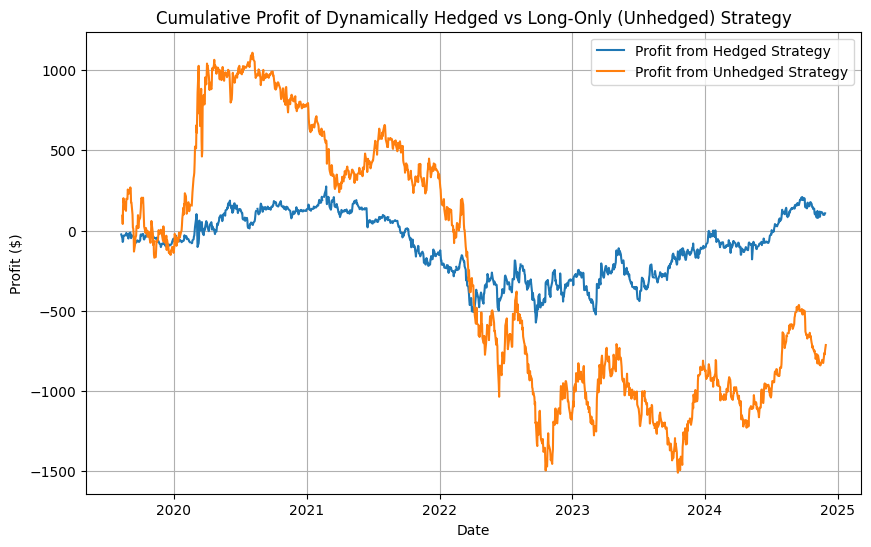

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(position.index, position['Profit Hedged'].cumsum(), label='Profit from Hedged Strategy')
plt.plot(position.index, position['Profit Unhedged'].cumsum(), label='Profit from Unhedged Strategy')
plt.title('Cumulative Profit of Dynamically Hedged vs Long-Only (Unhedged) Strategy')
plt.xlabel('Date')
plt.ylabel('Profit ($)')
plt.legend()
plt.grid()
plt.show()

In [83]:
profit_summary2 = position[['Profit Hedged','Profit Unhedged']].describe().drop(index=['count']).style.format('${:,.2f}')
profit_summary2

,Profit Hedged,Profit Unhedged
mean,$0.08,$-0.54
std,$21.13,$44.63
min,$-98.34,$-321.20
25%,$-10.97,$-26.48
50%,$0.00,$-1.46
75%,$10.56,$24.77
max,$118.43,$276.27


***